In [77]:
import sys, yaml
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.optimize import minimize, Bounds
from motoman_def import *

In [151]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def avg_by_line(job_line, flame_pos, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty((num_segs, 3))
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i,:] = average_pos[idx, :]
         else:
              output[i,:] = [None, None, None]
    #handle missing height data

    return output

class speedHeightModel:
    '''
    Model relating dh to torch speed according to the equation
    ln(h) = a ln(v) + b
    '''
    def __init__(self, coeff_a = -0.4619, coeff_b = 1.647):
        self.coeff_a = coeff_a
        self.coeff_b = coeff_b
    
    def v2dh(self, v):
        logdh = self.coeff_a*np.log(v)+self.coeff_b
    
        dh = np.exp(logdh)
        return dh
    
    def dh2v(self, dh):
        logdh = np.log(dh)
        logv = (logdh-self.coeff_b)/self.coeff_a
        
        v = np.exp(logv)
        return v
    
    def model_update(self, vels, dhs, weight):
        # Updates the model with new height-torchspeed data
        ln_vels = np.log(np.array(vels))
        ln_dhs = np.log(np.array(dhs))

        # Pseudo-inverse to calculate least squares fit based on new data
        x_mat = np.vstack((ln_vels, np.ones_like(ln_vels)))
        
        updated_coeff_mat = ln_dhs@np.linalg.pinv(x_mat)
        print(updated_coeff_mat)
        # print(self.coeff_a)
        # print(self.coeff_b)
        # Model Update
        if not np.any(np.isnan(updated_coeff_mat)):
            self.coeff_a = weight*updated_coeff_mat[0] + (1-weight)*self.coeff_a
            self.coeff_b = weight*updated_coeff_mat[1] + (1-weight)*self.coeff_b
        # print(self.coeff_a)
        # print(self.coeff_b)



In [79]:
dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/'
H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')

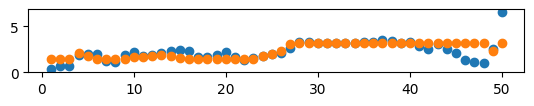

Original A coeff:  -0.4619
Original B coeff:  1.647
[-0.3164483   1.33544185]
-0.4619
1.647
-0.31644829502971555
1.3354418545514093
New A coeff:  -0.31644829502971555
New B coeff:  1.3354418545514093


In [124]:
layer = 45

with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
    flame_3d = pickle.load(file)
with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
    job_no = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
    flame_3d_prev = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
    job_no_prev = pickle.load(file)

vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
job_no = [i-4 for i in job_no]
job_no_prev = [i-4 for i in job_no_prev]

p = H[:3, -1]
R = H[:3, :3]

for i in range(flame_3d.shape[0]):
    flame_3d[i] = R.T@flame_3d[i]
for i in range(flame_3d_prev.shape[0]):
    flame_3d_prev[i] = R.T@flame_3d_prev[i]

layer_angle = angle*(layer-1)

layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z-base_thickness
new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
flame_3d_prev[:,0] = new_x
flame_3d_prev[:,2] = new_z-base_thickness
averages = avg_by_line(job_no, flame_3d, 50)
heights = averages[:,-1]
averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
heights_prev = averages_prev[:,-1]

# Check Direction Flags so directions match
if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
    heights = heights[::-1]
    vel_profile = vel_profile[::-1]
if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
    heights_prev = heights_prev[::-1]

dh = heights-heights_prev
model = speedHeightModel()
dh_model = model.v2dh(vel_profile)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.linspace(1,50,50), dh)
ax.scatter(np.linspace(1,50,50), dh_model)
ax.set_aspect('equal')
plt.show()

print("Original A coeff: ", model.coeff_a)
print("Original B coeff: ", model.coeff_b)
model.model_update(vel_profile[1:-2], dh[1:-2], weight=1)
print("New A coeff: ", model.coeff_a)
print("New B coeff: ", model.coeff_b)

[-0.3164483   1.33544185]
[-0.59931888  1.94405928]
[nan nan]
[-0.4027567   1.26937402]
[nan nan]
[-0.829494    1.88516322]
[nan nan]
[nan nan]
[-0.32563245  1.15703622]
[nan nan]
[nan nan]
[-0.58769241  1.74625194]
[-0.39587027  1.53599077]
[-0.33435899  1.38624567]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[-0.48175242  1.45605711]
[-0.38760259  1.43112078]
[-0.52994385  1.65448709]
[-1.02311302  2.33336603]
[-0.58017245  1.62760825]
[-0.41904571  1.3310748 ]
[-0.39553939  1.27834606]
[-0.50755145  1.40384843]
[-0.95732903  2.03181447]
[nan nan]
[nan nan]
[-0.69157076  1.57768278]
[-0.61175907  1.89480116]
[nan nan]
[nan nan]
[-0.23875854  1.18044857]


C:\Users\Jack\AppData\Local\Temp\ipykernel_18616\2818667521.py:99: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


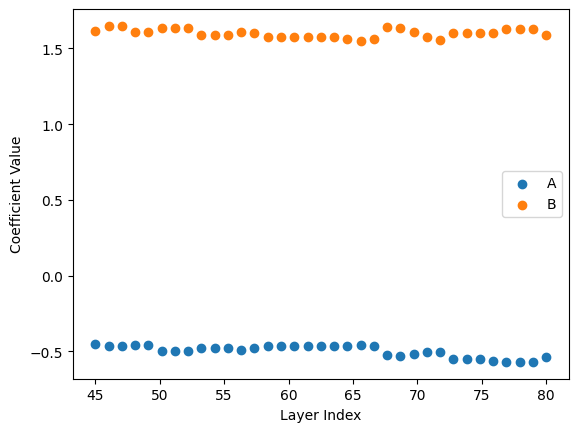

In [156]:
layer_start = 45
coeff_a = []
coeff_b = []
model = speedHeightModel()
for layer in range(layer_start,80):
    with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
        flame_3d = pickle.load(file)
    with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
        job_no = pickle.load(file)
    with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
        flame_3d_prev = pickle.load(file)
    with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
        job_no_prev = pickle.load(file)

    vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
    job_no = [i-4 for i in job_no]
    job_no_prev = [i-4 for i in job_no_prev]

    p = H[:3, -1]
    R = H[:3, :3]

    for i in range(flame_3d.shape[0]):
        flame_3d[i] = R.T@flame_3d[i]
    for i in range(flame_3d_prev.shape[0]):
        flame_3d_prev[i] = R.T@flame_3d_prev[i]

    layer_angle = angle*(layer-1)

    layer_angle=np.deg2rad(layer_angle)
    new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
    flame_3d[:,0] = new_x
    flame_3d[:,2] = new_z-base_thickness
    new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
    flame_3d_prev[:,0] = new_x
    flame_3d_prev[:,2] = new_z-base_thickness
    averages = avg_by_line(job_no, flame_3d, 50)
    heights = averages[:,-1]
    averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
    heights_prev = averages_prev[:,-1]

    # Check Direction Flags so directions match
    if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
        heights = heights[::-1]
        vel_profile = vel_profile[::-1]
    if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
        heights_prev = heights_prev[::-1]

    dh = heights-heights_prev
    dh_model = model.v2dh(vel_profile)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.scatter(np.linspace(1,50,50), dh)
    # ax.scatter(np.linspace(1,50,50), dh_model)
    # ax.set_aspect('equal')
    # plt.show()

    # print("Original A coeff: ", model.coeff_a)
    # print("Original B coeff: ", model.coeff_b)
    model.model_update(vel_profile[1:-2], dh[1:-2], weight=0.1)
    # print("New A coeff: ", model.coeff_a)
    # print("New B coeff: ", model.coeff_b)
    coeff_a.append(model.coeff_a)
    coeff_b.append(model.coeff_b)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a),len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b),len(coeff_b)), coeff_b)
plt.legend(("A", "B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.show()
    